In [5]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.observer import _Tracker
from bayes_opt.target_space import TargetSpace
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from PIL import Image
from tensorflow import keras
from glob import glob
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import json

In [39]:
v_bound_min = 10
v_bound_max = 20
pc_bound_min = 0
pc_bound_max = 5
h_bound_min = 0.15
h_bound_max = 0.65
count = 0
image_threshold = 100
log = {1:{}}
url_str = "/Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/logs/GO_ink_optimization_log"
initial_search = 5
number_of_iterations = 45
p_min = 24
patience = 0.1
camera_width_pixel_resolution = 800

In [40]:
def image_analyser(image_url, v, p_c, h):
    
    #grayScaledImage = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)
    #image = cv2.resize(grayScaledImage, (128,128))
    #image = np.array(image)

    #image = image.reshape(1,image.shape[0],image.shape[1],1)
    #image = image.astype(np.float32) / 255.

    #y_pred_onehot = cnn_model.predict(image)
    #y_pred = y_pred_onehot.argmax(axis=1)
    
    y_pred = [int(input("y_pred : "))]
    
    global const
    global count
    global pc_bound_min
    global pc_bound_max
    
    log[count] = {}
    log[count]["v"] = v
    log[count]["p"] = p_c * v + p_min
    log[count]["h"] = h
    
    if y_pred == [0]:
        print("discontinuous line")
        log[count]["s"] = "discontinuous"
        
        discontinuous_pc = []
    
        for i in log:
            if log[i]["s"] == "discontinuous":
                min_pressure_constant = (log[i]["p"] - p_min) / log[i]["v"]
                discontinuous_pc.append(min_pressure_constant)
            
        if discontinuous_pc:
            pc_bound_min = np.array(discontinuous_pc).max() - patience
            log[count]["pc_bound_min"] = pc_bound_min
            print("pc_bound_min : ", pc_bound_min)
        
    elif y_pred == [1]:
        print("straight line")
        log[count]["s"] = "straight"
        
        
    elif y_pred == [2] or y_pred == [3]:
        print("coiled or accumulated")
        log[count]["s"] = "coiled_or_accumulated"
        
        coiled_or_aggregated_pc = []
    
        for i in log:
            if log[i]["s"] == "coiled_or_accumulated":
                max_pressure_constant = (log[i]["p"] - p_min) / log[i]["v"]
                coiled_or_aggregated_pc.append(max_pressure_constant)
            
        if coiled_or_aggregated_pc:
            pc_bound_max = np.array(coiled_or_aggregated_pc).min() + patience
            log[count]["pc_bound_max"] = pc_bound_max
            print("pc_bound_max : ", pc_bound_max)
    
    if pc_bound_min > pc_bound_max:
        print("(warning) pc boundaries collapsed... ")
    
    #optimizer.set_bounds(new_bounds={'velocity': (v_bound_min, v_bound_max), 'pressure_constant': (pc_bound_min, pc_bound_max), 
    #                                 'height': (h_bound_min, h_bound_max)})
    
    result = calculate_score(image_url)
    
    log[count]["score"] = -result[0]
    log[count]["width"] = result[1]
    
    
    return -result[0]

def calculate_score(image):
    
    grayScaledImage = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    ret, processedImage = cv2.threshold(grayScaledImage, image_threshold, 255, cv2.THRESH_BINARY)
    
    h, w = processedImage.shape
    
    total_counts = []
    
    for i in range(w):
        
        count = 0
        for j in range(h):
            if processedImage[j][i] == 0:
                count += 1
    
        if count != 0:
            total_counts.append(count)
    
    if len(total_counts) > camera_width_pixel_resolution / 2:
        line_std = np.std(total_counts) * camera_width_pixel_resolution / len(total_counts)
        line_pixel_width = np.mean(total_counts)
    else:
        line_std = camera_width_pixel_resolution/40 + 10
        line_pixel_width = 0
    
    result = [line_std, line_pixel_width]
    print("score : ", line_std, "   line width : ", line_pixel_width)
    
    return result

def black_box_function(velocity, pressure_constant, height):
    
    global count
    
    count += 1
    
    print(" ----- iteration ", count, " ----- ")
    print("V : ", round(velocity, 2))
    print("P : ", round(pressure_constant * velocity + p_min,1))
    print("H : ", round(height, 2))
    print("pc", pressure_constant)
    
    image_url = str(input("enter image url : "))
    
    score = image_analyser(image_url, velocity, pressure_constant, height)
    
    return score

In [41]:
pbounds = {'velocity': (v_bound_min, v_bound_max), 'pressure_constant': (pc_bound_min, pc_bound_max), 
           'height': (h_bound_min, h_bound_max)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2,
    random_state=987234,
)

logger = JSONLogger(path = url_str + ".json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=5,
    n_iter=0,
    acq="ucb", 
    xi=2.576,
)

 ----- iteration  1  ----- 
V :  12.26
P :  69.7
H :  0.2
pc 3.7308535785021175
enter image url : /Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/images/bayes_pedot_1.bmp
y_pred : 1
straight line
score :  2.241469790190793    line width :  51.465495608531995
 ----- iteration  2  ----- 
V :  10.96
P :  33.7
H :  0.17
pc 0.8816969481206821
enter image url : /Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/images/bayes_pedot_2.bmp
y_pred : 0
discontinuous line
pc_bound_min :  0.781696948120682
score :  30.0    line width :  0
 ----- iteration  3  ----- 
V :  14.74
P :  42.7
H :  0.51
pc 1.2681115289028377
enter image url : /Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/images/bayes_pedot_3.bmp
y_pred : 0
discontinuous line
pc_bound_min :  1.1681115289028379
score :  30.0    line width :  0
 ----- iteration  4  ----- 
V :  18.84
P :  78.4
H :  0.5
pc 2.885222111625243
enter image url : /Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/images/bayes_pedot_4.bmp


In [89]:
optimizer.set_bounds(new_bounds={'velocity': (10,20), 'pressure_constant': (1.694, 2.0952), 
                                     'height': (0.15,0.65)})

optimizer.maximize(
    init_points=0,
    n_iter=1,
    acq="ucb", 
    xi=2.576,
)

 ----- iteration  52  ----- 
V :  18.94
P :  56.6
H :  0.63
pc 1.7198208171006568
enter image url : /Users/jonghyun/Desktop/bayesian_optimization/bo_p_0726/images/bayes_pedot_52.bmp
y_pred : 1
straight line
score :  2.578318274771898    line width :  41.780426599749056


In [32]:
print(log)

{1: {'v': 12.259491212275519, 'p': 69.73836665993338, 'h': 0.20298069735607285, 's': 'straight', 'score': -2.241469790190793, 'width': 51.465495608531995}, 2: {'v': 10.958999649787414, 'p': 33.662516545673185, 'h': 0.16789805049007053, 's': 'discontinuous', 'pc_bound_min': 0.781696948120682, 'score': -30.0, 'width': 0}, 3: {'v': 14.744889972132821, 'p': 42.69816496606548, 'h': 0.5053502020714115, 's': 'discontinuous', 'pc_bound_min': 1.1681115289028379, 'score': -30.0, 'width': 0}, 4: {'v': 18.8442749281239, 'p': 78.36991870016827, 'h': 0.4960398961030825, 's': 'straight', 'score': -3.2786319276733527, 'width': 69.48933500627352}, 5: {'v': 14.484019070096643, 'p': 60.44589280729961, 'h': 0.3626788806629587, 's': 'straight', 'score': -2.2745827546464232, 'width': 50.76662484316186}, 6: {'v': 17.85592361003668, 'p': 55.95384988202683, 'h': 0.22681556665831862, 's': 'discontinuous', 'pc_bound_min': 1.6895377791639863, 'score': -30.0, 'width': 0}, 7: {'v': 13.567030795989975, 'p': 58.67415

In [90]:
print(log)

{1: {'v': 12.259491212275519, 'p': 69.73836665993338, 'h': 0.20298069735607285, 's': 'straight', 'score': -2.241469790190793, 'width': 51.465495608531995}, 2: {'v': 10.958999649787414, 'p': 33.662516545673185, 'h': 0.16789805049007053, 's': 'discontinuous', 'pc_bound_min': 0.781696948120682, 'score': -30.0, 'width': 0}, 3: {'v': 14.744889972132821, 'p': 42.69816496606548, 'h': 0.5053502020714115, 's': 'discontinuous', 'pc_bound_min': 1.1681115289028379, 'score': -30.0, 'width': 0}, 4: {'v': 18.8442749281239, 'p': 78.36991870016827, 'h': 0.4960398961030825, 's': 'straight', 'score': -3.2786319276733527, 'width': 69.48933500627352}, 5: {'v': 14.484019070096643, 'p': 60.44589280729961, 'h': 0.3626788806629587, 's': 'straight', 'score': -2.2745827546464232, 'width': 50.76662484316186}, 6: {'v': 17.85592361003668, 'p': 63.755360346456285, 'h': 0.22681556665831862, 's': 'straight', 'score': -4.15899815743325, 'width': 51.10790464240903}, 7: {'v': 13.567030795989975, 'p': 63.10082534404116, '

In [92]:
log = {1: {'v': 12.259491212275519, 'p': 69.73836665993338, 'h': 0.20298069735607285, 's': 'straight', 'score': -2.241469790190793, 'width': 51.465495608531995}, 2: {'v': 10.958999649787414, 'p': 33.662516545673185, 'h': 0.16789805049007053, 's': 'discontinuous', 'pc_bound_min': 0.781696948120682, 'score': -30.0, 'width': 0}, 3: {'v': 14.744889972132821, 'p': 42.69816496606548, 'h': 0.5053502020714115, 's': 'discontinuous', 'pc_bound_min': 1.1681115289028379, 'score': -30.0, 'width': 0}, 4: {'v': 18.8442749281239, 'p': 78.36991870016827, 'h': 0.4960398961030825, 's': 'straight', 'score': -3.2786319276733527, 'width': 69.48933500627352}, 5: {'v': 14.484019070096643, 'p': 60.44589280729961, 'h': 0.3626788806629587, 's': 'straight', 'score': -2.2745827546464232, 'width': 50.76662484316186}, 6: {'v': 17.85592361003668, 'p': 63.755360346456285, 'h': 0.22681556665831862, 's': 'straight', 'score': -4.15899815743325, 'width': 51.10790464240903}, 7: {'v': 13.567030795989975, 'p': 63.10082534404116, 'h': 0.4367177827919537, 's': 'coiled_or_accumulated', 'pc_bound_max': 2.98204736408487, 'score': -5.591959311543552, 'width': 65.3513174404015}, 8: {'v': 18.73715484463817, 'p': 63.56728384886549, 'h': 0.17080290414761642, 's': 'straight', 'score': -3.2864454499523723, 'width': 54.063989962358846}, 9: {'v': 15.590602930448748, 'p': 70.49117793859817, 'h': 0.15, 's': 'straight', 'score': -7.089689703666734, 'width': 78.61731493099121}, 10: {'v': 20.0, 'p': 63.903209212022844, 'h': 0.65, 's': 'coiled_or_accumulated', 'pc_bound_max': 2.095160460601142, 'score': -13.673160333177945, 'width': 67.00752823086574}, 11: {'v': 16.916658227917022, 'p': 52.58069407606581, 'h': 0.65, 's': 'discontinuous', 'pc_bound_min': 1.5895000000000001, 'score': -30.0, 'width': 0}, 12: {'v': 12.548407820538433, 'p': 50.291424065592125, 'h': 0.65, 's': 'straight', 'score': -2.2743972544847746, 'width': 40.54077791718946}, 13: {'v': 13.235755318565134, 'p': 49.49257323559895, 'h': 0.15, 's': 'straight', 'score': -2.3266452113633633, 'width': 40.96612296110414}, 14: {'v': 11.953447991334455, 'p': 49.04486423144395, 'h': 0.15, 's': 'straight', 'score': -2.382160702627699, 'width': 40.96235884567127}, 15: {'v': 10.0, 'p': 44.952, 'h': 0.65, 's': 'straight', 'score': -3.5133039224762546, 'width': 42.10037641154329}, 16: {'v': 11.17055448754138, 'p': 47.404545762296706, 'h': 0.65, 's': 'straight', 'score': -5.219602974419858, 'width': 47.234629861982434}, 17: {'v': 18.453864489985804, 'p': 55.17780405583102, 'h': 0.65, 's': 'discontinuous', 'pc_bound_min': 1.5895000000000001, 'score': -5.204158354956089, 'width': 40.04207573632539}, 18: {'v': 12.571754620531486, 'p': 45.239979431387944, 'h': 0.15, 's': 'discontinuous', 'pc_bound_min': 1.5895000000000001, 'score': -9.890844403507652, 'width': 35.55993690851735}, 19: {'v': 13.634873230006685, 'p': 52.56778639151001, 'h': 0.65, 's': 'straight', 'score': -5.785479131415293, 'width': 45.29360100376412}, 20: {'v': 10.0, 'p': 44.952, 'h': 0.15, 's': 'straight', 'score': -3.9287270523869693, 'width': 37.568381430363864}, 21: {'v': 11.890375103022869, 'p': 48.912713915853516, 'h': 0.65, 's': 'straight', 'score': -3.457458119596409, 'width': 42.58092848180677}, 22: {'v': 13.875283462851005, 'p': 52.94490708477696, 'h': 0.17522376544052373, 's': 'discontinuous', 'pc_bound_min': 1.9860768114952472, 'score': -14.569191869845822, 'width': 35.03383458646616}, 23: {'v': 19.037617287528104, 'p': 58.96777709992057, 'h': 0.37872342205859777, 's': 'straight', 'score': -2.6928202294506507, 'width': 44.79046424090339}, 24: {'v': 11.654493512659757, 'p': 48.045150556085275, 'h': 0.4804611740193946, 's': 'straight', 'score': -2.8722353809036933, 'width': 42.01505646173149}, 25: {'v': 13.077443921065052, 'p': 51.399860503415496, 'h': 0.65, 's': 'straight', 'score': -3.7393895581062293, 'width': 44.68130489335006}, 26: {'v': 10.750833502724491, 'p': 46.52514635490836, 'h': 0.15, 's': 'straight', 'score': -5.016975025696635, 'width': 39.57841907151819}, 27: {'v': 18.283517716029703, 'p': 55.00924783618355, 'h': 0.15693906002014693, 's': 'straight', 'score': -3.991155745264542, 'width': 41.07402760351317}, 28: {'v': 18.885133136704223, 'p': 63.56813094802269, 'h': 0.65, 's': 'straight', 'score': -12.478634044494056, 'width': 52.9861982434128}, 29: {'v': 18.179925311153067, 'p': 59.28296102303542, 'h': 0.6424548049817808, 's': 'straight', 'score': -1.8447856118357946, 'width': 36.8030112923463}, 30: {'v': 19.584073238609786, 'p': 62.50477625990902, 'h': 0.3315636681685896, 's': 'straight', 'score': -2.792550920408559, 'width': 39.36511919698871}, 31: {'v': 19.371752898956967, 'p': 56.7285765227878, 'h': 0.15, 's': 'straight', 'score': -4.438103114010206, 'width': 47.64366373902133}, 32: {'v': 10.966453766631668, 'p': 43.67330301982396, 'h': 0.503947808687847, 's': 'discontinuous', 'pc_bound_min': 1.9860768114952472, 'score': -13.411772115862739, 'width': 36.62061403508772}, 33: {'v': 17.48728207067417, 'p': 55.004983248460256, 'h': 0.4533256605341539, 's': 'straight', 'score': -2.4290562714674016, 'width': 41.7741530740276}, 34: {'v': 17.73721431357164, 'p': 54.046841047190355, 'h': 0.15, 's': 'straight', 'score': -2.583754525689909, 'width': 38.52446675031368}, 35: {'v': 18.229978266949555, 'p': 60.2136733039669, 'h': 0.6322179918689007, 's': 'straight', 'score': -7.087895852981315, 'width': 55.72145545796738}, 36: {'v': 18.1231846248171, 'p': 55.75623115201138, 'h': 0.6114951156491709, 's': 'straight', 'score': -2.5887921637691007, 'width': 37.569636135508155}, 37: {'v': 17.936530201408218, 'p': 58.80708049833889, 'h': 0.648369316729847, 's': 'straight', 'score': -4.803268513718996, 'width': 49.223337515683816}, 38: {'v': 17.50462303053383, 'p': 55.10674320672154, 'h': 0.4482335908277588, 's': 'discontinuous', 'pc_bound_min': 1.9860768114952472, 'score': -10.345277087506608, 'width': 39.99363057324841}, 39: {'v': 19.00711913803204, 'p': 59.21113063459468, 'h': 0.20780126548419056, 's': 'straight', 'score': -2.3347003004015434, 'width': 36.05269761606023}, 40: {'v': 11.244705422758674, 'p': 44.36877602599222, 'h': 0.19644037939062378, 's': 'straight', 'score': -6.302926953815765, 'width': 39.07124681933842}, 41: {'v': 14.939737710933535, 'p': 52.89660570959214, 'h': 0.5487648467461503, 's': 'straight', 'score': -2.450791875011269, 'width': 40.499372647427855}, 42: {'v': 10.66160534818647, 'p': 45.18721177361882, 'h': 0.281878680572328, 's': 'straight', 'score': -2.8583833150465794, 'width': 39.08657465495609}, 43: {'v': 16.959533746194758, 'p': 58.099185791204015, 'h': 0.5571094986074913, 's': 'straight', 'score': -7.381394796948587, 'width': 47.956085319949814}, 44: {'v': 10.658588621932974, 'p': 45.159060945479965, 'h': 0.33674466261498326, 's': 'straight', 'score': -2.6864682677131224, 'width': 37.85821831869511}, 45: {'v': 12.66749406114676, 'p': 45.96554801910979, 'h': 0.5246106989543262, 's': 'discontinuous', 'pc_bound_min': 1.9860768114952472, 'score': -11.934503518115473, 'width': 32.12471131639723}, 46: {'v': 18.822866219140266, 'p': 60.857763335257154, 'h': 0.2988374221611865, 's': 'straight', 'score': -4.0701743508965205, 'width': 49.185696361355085}, 47: {'v': 18.291344849145986, 'p': 56.042680527658156, 'h': 0.5574417448968411, 's': 'straight', 'score': -3.6786992872750077, 'width': 42.92848180677541}, 48: {'v': 11.446105882621213, 'p': 44.53051785597545, 'h': 0.2991530185149417, 's': 'straight', 'score': -1.9207874950987107, 'width': 40.0564617314931}, 49: {'v': 15.607761298113829, 'p': 54.12862059747958, 'h': 0.363219474558765, 's': 'straight', 'score': -3.486501624655138, 'width': 43.89711417816813}, 50: {'v': 18.94048065841376, 'p': 56.57423292223234, 'h': 0.6286855354719519, 's': 'straight', 'score': -2.578318274771898, 'width': 41.780426599749056}}

/Users/jonghyun/opt/anaconda3/envs/chem_ai/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


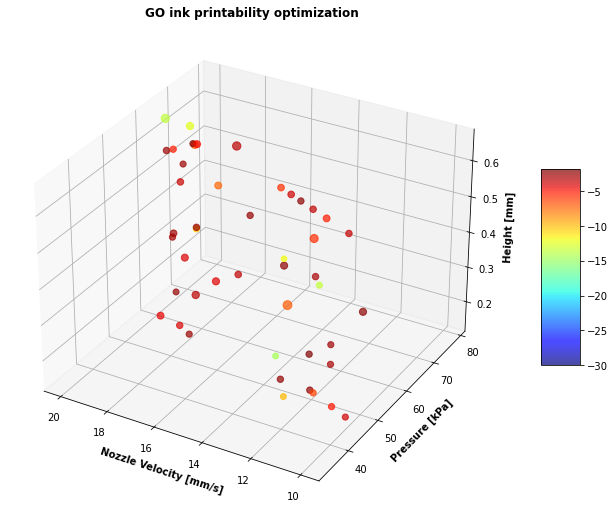

In [94]:
height = []
pressure = []
velocity = []
target = []
m = []
for i in log:
    height.append(log[i]["h"])
    pressure.append(log[i]["p"])
    velocity.append(log[i]["v"])
    target.append(log[i]["score"])
    m.append(log[i]["width"])
    
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
z = height
x = velocity
y = pressure
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

ax.invert_xaxis()
ax.invert_yaxis()
 
# Creating color map
my_cmap = plt.get_cmap('jet')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    s = m,
                    alpha = 0.7,
                    c = target,
                    cmap = my_cmap,
                    marker = 'o')
 
plt.title("GO ink printability optimization", fontweight ='bold')
ax.set_xlabel('Nozzle Velocity [mm/s]', fontweight ='bold')
ax.set_ylabel('Pressure [kPa]', fontweight ='bold')
ax.set_zlabel('Height [mm]', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.4, aspect = 5)



# show plot
plt.show()

/Users/jonghyun/opt/anaconda3/envs/chem_ai/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


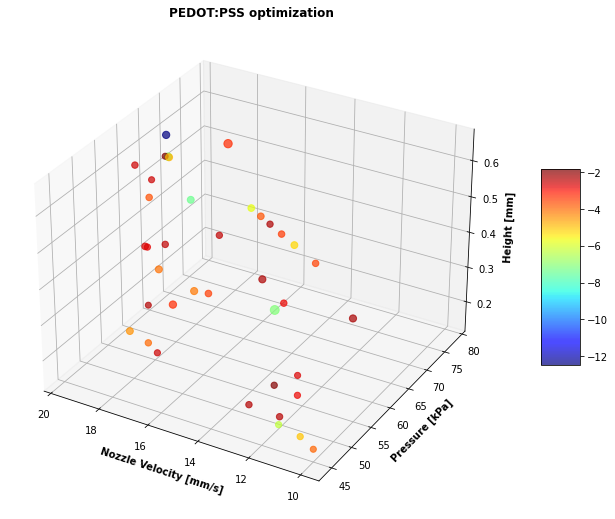

In [98]:
height = []
pressure = []
velocity = []
target = []
m = []
for i in log:
    if log[i]["s"] == "straight":
        height.append(log[i]["h"])
        pressure.append(log[i]["p"])
        velocity.append(log[i]["v"])
        target.append(log[i]["score"])
        m.append(log[i]["width"])
    
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
z = height
x = velocity
y = pressure
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

ax.invert_xaxis()
ax.invert_yaxis()
 
# Creating color map
my_cmap = plt.get_cmap('jet')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    s = m,
                    alpha = 0.7,
                    c = target,
                    cmap = my_cmap,
                    marker = 'o')
 
plt.title("PEDOT:PSS optimization", fontweight ='bold')
ax.set_xlabel('Nozzle Velocity [mm/s]', fontweight ='bold')
ax.set_ylabel('Pressure [kPa]', fontweight ='bold')
ax.set_zlabel('Height [mm]', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.4, aspect = 5)



# show plot
plt.show()

In [95]:
pressure_rounded = [round(num, 1) for num in pressure]
velocity_rounded = [round(vel, 2) for vel in velocity]
height_rounded = [round(h, 2) for h in height]
target_rounded = [round(t, 2) * (-1) for t in target]
mean_rounded = [round(i, 1) for i in m]

import numpy as np
import pandas as pd

bayes_opt_data = [pressure_rounded, velocity_rounded, height_rounded, target_rounded, mean_rounded]
df = pd.DataFrame(bayes_opt_data).T
df.index = np.arange(1,51)

df.columns = ["pressure", "velocity", "height", "standard deviation", "mean [pixel]"]
mean_rounded_mm = round(df["mean [pixel]"] * 0.008125, 3)
df["mean [mm]"] = mean_rounded_mm
df

,pressure,velocity,height,standard deviation,mean [pixel],mean [mm]
1,69.7,12.26,0.20,2.24,51.5,0.418
2,33.7,10.96,0.17,30.00,0.0,0.000
3,42.7,14.74,0.51,30.00,0.0,0.000
4,78.4,18.84,0.50,3.28,69.5,0.565
5,60.4,14.48,0.36,2.27,50.8,0.413
6,63.8,17.86,0.23,4.16,51.1,0.415
7,63.1,13.57,0.44,5.59,65.4,0.531
8,63.6,18.74,0.17,3.29,54.1,0.440
9,70.5,15.59,0.15,7.09,78.6,0.639
10,63.9,20.00,0.65,13.67,67.0,0.544


In [99]:
df[df["standard deviation"] < 5].sort_values(by="standard deviation", ascending = True)

,pressure,velocity,height,standard deviation,mean [pixel],mean [mm]
29,59.3,18.18,0.64,1.84,36.8,0.299
48,44.5,11.45,0.30,1.92,40.1,0.326
1,69.7,12.26,0.20,2.24,51.5,0.418
12,50.3,12.55,0.65,2.27,40.5,0.329
5,60.4,14.48,0.36,2.27,50.8,0.413
13,49.5,13.24,0.15,2.33,41.0,0.333
39,59.2,19.01,0.21,2.33,36.1,0.293
14,49.0,11.95,0.15,2.38,41.0,0.333
33,55.0,17.49,0.45,2.43,41.8,0.340
41,52.9,14.94,0.55,2.45,40.5,0.329
